### XGBoost on Rental Listing Inquiries

In [1]:
#import tools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier  
import xgboost as xgb  

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss
%matplotlib inline

### Get best n_estimators by CV
#### 1. Load and prepare data

In [26]:
o_train = pd.read_csv('../RentListingInquries_FE_train.csv')
test = pd.read_csv('../RentListingInquries_FE_test.csv')
train.head()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
1,1.0,2,40.7947,-73.9667,5465,2732.5,1821.666667,-1.0,3.0,2016,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,40.7388,-74.0018,2850,1425.0,1425.000000,0.0,2.0,2016,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,40.7539,-73.9677,3275,1637.5,1637.500000,0.0,2.0,2016,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,40.8241,-73.9493,3350,1675.0,670.000000,-3.0,5.0,2016,...,0,0,1,0,0,0,0,0,0,2
5,2.0,4,40.7429,-74.0028,7995,2665.0,1599.000000,-2.0,6.0,2016,...,0,0,0,0,0,0,0,0,0,1


In [4]:
# observe interest_level distribution
train.interest_level.value_counts()

2    671
1    250
0     78
Name: interest_level, dtype: int64

In [5]:
#set X, y
y_train = train['interest_level']
X_train = train.drop('interest_level', axis =1)

#prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

#### 2. Define function: get n_estimators by CV, and use n_estimators to fit model

In [6]:
#run grid search with 5-fold cross-validation and see which parameters perform the best.
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3         
    
    xgtrain = xgb.DMatrix(X_train, label = y_train)
    
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'],
                     folds = cv_folds, metrics = 'mlogloss', early_stopping_rounds = early_stopping_rounds)
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #best n_estimators
    n_estimators = cvresult.shape[0]
    
    #use best n_estimators to fit model
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric = 'mlogloss')
    
    #predict
    train_predprob = alg.predict_proba(X_train)   ##### 老师写错了
    logloss = log_loss(y_train, train_predprob)

In [7]:
xgb1 = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 5,
                    min_child_weight = 1, gamma = 0, subsample = 0.3, 
                    colsample_bytree = 0.8, colsample_bylevel = 0.7,
                    objective = 'multi:softprob', seed = 3)
modelfit(xgb1, X_train, y_train, cv_folds = kfold)  

#### 3. Draw plot of n_estimators and loss 

<function matplotlib.pyplot.show>

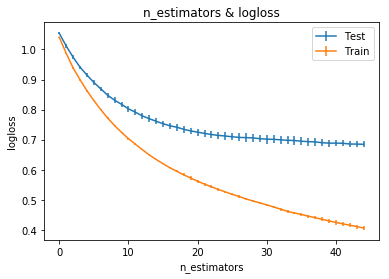

In [8]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')

test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std']
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std']
    
x_axis = range(0, cvresult.shape[0])

plt.errorbar(x_axis, test_means, yerr = test_stds, label = 'Test')
plt.errorbar(x_axis, train_means, yerr = train_stds, label = 'Train') 
plt.title('n_estimators & logloss')
plt.xlabel('n_estimators')
plt.ylabel('logloss')
plt.savefig('n_estimators_w3_1.png')
plt.legend()
plt.show

### Tuning max_depth & min_child_weight
#### Tuning with a rough range at first

In [9]:
max_depth = range(3, 10, 2)
min_child_weight = range(1, 6, 2)
param_test_w3_1 = dict(max_depth = max_depth, min_child_weight = min_child_weight)

xgb2 = XGBClassifier(max_depth = 5, e_estimators = 34, min_child_weight = 1, gamma = 1, subsample = 0.3,
                     colsample_bytree = 0.8, colsample_bylevel = 0.7, objective = 'multi:softprob', seed = 3)
gsearch_w3_1 = GridSearchCV(xgb2, param_grid = param_test_w3_1, scoring = 'neg_log_loss', n_jobs = -1, cv=kfold)
gsearch_w3_1.fit(X_train, y_train)
#GridSearchCV.score to evaluate
gsearch_w3_1.grid_scores_, gsearch_w3_1.best_params_, gsearch_w3_1.best_score_

/Users/hankaei/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.68405, std: 0.02878, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.69185, std: 0.03538, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.69332, std: 0.03873, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.70796, std: 0.04308, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.70760, std: 0.03447, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.70103, std: 0.03527, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.71049, std: 0.04758, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.69924, std: 0.03649, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.70824, std: 0.03297, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.71124, std: 0.04100, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.70120, std: 0.03952, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.69792, std: 0.03819, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_chil

In [10]:
gsearch_w3_1.cv_results_

{'mean_fit_time': array([ 1.10453796,  1.11422091,  1.1603126 ,  1.66691556,  1.56404686,
         1.42076993,  1.97334757,  1.96590028,  1.68173122,  2.21690063,
         1.89632192,  1.46459804]),
 'mean_score_time': array([ 0.00808082,  0.01233101,  0.00950356,  0.00796685,  0.00727458,
         0.00802407,  0.00835652,  0.00793653,  0.00925794,  0.00940857,
         0.00724878,  0.00557199]),
 'mean_test_score': array([-0.68405283, -0.6918546 , -0.69331813, -0.70795575, -0.70759705,
        -0.70103479, -0.71049304, -0.69924149, -0.70823896, -0.71123926,
        -0.70120064, -0.69792458]),
 'mean_train_score': array([-0.43223439, -0.46157769, -0.49278257, -0.32543454, -0.38006213,
        -0.43483508, -0.28897043, -0.35690573, -0.42645101, -0.28005367,
        -0.34925959, -0.42246502]),
 'param_max_depth': masked_array(data = [3 3 3 5 5 5 7 7 7 9 9 9],
              mask = [False False False False False False False False False False False False],
        fill_value = ?),
 'param_m

Best score: -0.684053 using {'max_depth': 3, 'min_child_weight': 1}


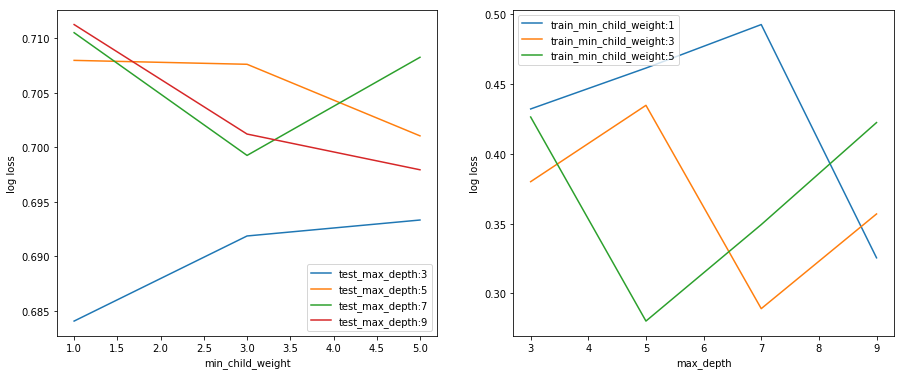

In [11]:
#make plot of results
print('Best score: %f using %s' % (gsearch_w3_1.best_score_, gsearch_w3_1.best_params_))
test_means_gs = gsearch_w3_1.cv_results_['mean_test_score']
test_stds_gs = gsearch_w3_1.cv_results_['std_test_score']
train_means_gs = gsearch_w3_1.cv_results_['mean_train_score']
train_stds_gs = gsearch_w3_1.cv_results_['std_train_score']

pd.DataFrame(gsearch_w3_1.cv_results_).to_csv('preds_maxdepth_min_child_weights_w3_1.csv')

test_scores = np.array(test_means_gs).reshape(len(max_depth), len(min_child_weight))
train_scores = np.array(train_means_gs).reshape(len(min_child_weight), len(max_depth))

plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
for i,value in enumerate(max_depth):
    plt.plot(min_child_weight, -test_scores[i], label = 'test_max_depth:'+str(value))
    
plt.legend()
plt.xlabel('min_child_weight')
plt.ylabel('log loss')

plt.subplot(1,2,2)
for i,value in enumerate(min_child_weight):
    plt.plot(max_depth, -train_scores[i], label = 'train_min_child_weight:'+str(value))
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('log loss')
plt.show()

#### Tuning with small range

In [12]:
#tuning in range（3，5）
max_depth = [2, 3, 4]
min_child_weight = [4, 5, 6]
param_test_w3_2 = dict(max_depth = max_depth, min_child_weight = min_child_weight)

xgb2_2 = XGBClassifier(max_depth = 5, n_estimators = 34, min_child_weight = 1, subsample = 0.3, 
                       colsample_bytree = 0.8, colsample_bylevel = 0.7, objective = 'multi:softprob',
                       seed = 3)
gsearch_w3_2 = GridSearchCV(xgb2_2, param_grid = param_test_w3_2, scoring = 'neg_log_loss', n_jobs = -1, cv=kfold)
gsearch_w3_2.fit(X_train, y_train)
gsearch_w3_2.grid_scores_, gsearch_w3_2.best_params_, gsearch_w3_2.best_score_

/Users/hankaei/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.71076, std: 0.01220, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -0.71304, std: 0.01222, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: -0.71495, std: 0.01374, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -0.70120, std: 0.01313, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -0.70406, std: 0.01345, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.70565, std: 0.01324, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -0.70213, std: 0.02056, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.70204, std: 0.02136, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.70695, std: 0.01374, params: {'max_depth': 4, 'min_child_weight': 6}],
 {'max_depth': 3, 'min_child_weight': 4},
 -0.70120027621795944)

In [13]:
gsearch_w3_2.cv_results_

{'mean_fit_time': array([ 0.29335361,  0.30705056,  0.31201406,  0.40320086,  0.44181409,
         0.42034993,  0.46512699,  0.43320498,  0.38136725]),
 'mean_score_time': array([ 0.00700364,  0.0050108 ,  0.00527477,  0.0050343 ,  0.00697274,
         0.00640545,  0.00473652,  0.0048326 ,  0.00401158]),
 'mean_test_score': array([-0.71075862, -0.71303902, -0.71495219, -0.70120028, -0.70405603,
        -0.70565332, -0.70212701, -0.70203845, -0.70694777]),
 'mean_train_score': array([-0.64752996, -0.65092892, -0.65376208, -0.6001783 , -0.60697387,
        -0.61357977, -0.56449067, -0.57634988, -0.5882675 ]),
 'param_max_depth': masked_array(data = [2 2 2 3 3 3 4 4 4],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [4 5 6 4 5 6 4 5 6],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 2, 'min_child_weight': 4

Best score: -0.701200 using {'max_depth': 3, 'min_child_weight': 4}


<function matplotlib.pyplot.show>

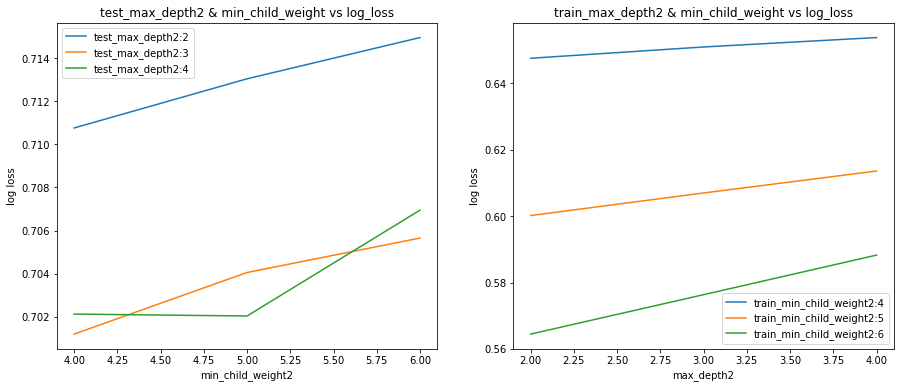

In [14]:
# make plot of results
print('Best score: %f using %s' % (gsearch_w3_2.best_score_, gsearch_w3_2.best_params_))
test_means_gs2 = gsearch_w3_2.cv_results_['mean_test_score']
test_stds_gs2 = gsearch_w3_2.cv_results_['std_test_score']
train_means_gs2 = gsearch_w3_2.cv_results_['mean_train_score']
train_stds_gs2 = gsearch_w3_2.cv_results_['std_train_score']

pd.DataFrame(gsearch_w3_2.cv_results_).to_csv('preds_maxdepth_min_child_weights_w3_2.csv')

test_scores2 = np.array(test_means_gs2).reshape(len(max_depth), len(min_child_weight))
train_scores2 = np.array(train_means_gs2).reshape(len(min_child_weight), len(max_depth))

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
for i,value in enumerate(max_depth):
    plt.plot(min_child_weight, -test_scores2[i], label = 'test_max_depth2:'+str(value))
    
plt.legend()
plt.title('test_max_depth2 & min_child_weight vs log_loss')
plt.xlabel('min_child_weight2')
plt.ylabel('log loss')

plt.subplot(1, 2, 2)
for i,value in enumerate(min_child_weight):
    plt.plot(max_depth, -train_scores2[i], label = 'train_min_child_weight2:'+str(value))
plt.legend()
plt.title('train_max_depth2 & min_child_weight vs log_loss')
plt.xlabel('max_depth2')
plt.ylabel('log loss')
plt.show

### Tuning e_estimators again 

    test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0             1.050192           0.003169             1.046012   
1             1.005886           0.001730             0.996636   
2             0.969363           0.001808             0.953430   
3             0.938848           0.006026             0.917693   
4             0.909515           0.006124             0.885118   
5             0.886599           0.004781             0.856064   
6             0.864126           0.005451             0.829969   
7             0.843447           0.005859             0.805971   
8             0.828747           0.008010             0.786468   
9             0.814495           0.007638             0.767548   
10            0.801324           0.005878             0.749477   
11            0.787391           0.005552             0.732271   
12            0.777403           0.004934             0.717411   
13            0.766409           0.003142             0.704604   
14        

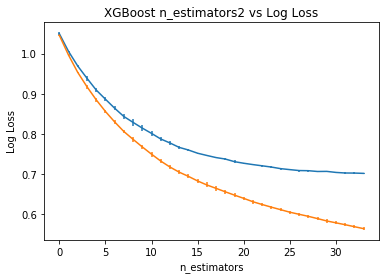

In [15]:
#n_estimators is 34 at the first time
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 3
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
                         metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print (cvresult)
        cvresult.to_csv('my_preds4_2_3_699.csv', index_label = 'n_estimators')
        
        # plot
        test_means_nesti2 = cvresult['test-mlogloss-mean']
        test_stds_nesti2 = cvresult['test-mlogloss-std'] 
        
        train_means_nesti2 = cvresult['train-mlogloss-mean']
        train_stds_nesti2 = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        plt.errorbar(x_axis, test_means_nesti2, yerr=test_stds_nesti2 ,label='Test')
        plt.errorbar(x_axis, train_means_nesti2, yerr=train_stds_nesti2 ,label='Train')
        plt.title("XGBoost n_estimators2 vs Log Loss")
        plt.xlabel( 'n_estimators' )
        plt.ylabel( 'Log Loss' )
        plt.savefig( 'n_estimators_w3_2.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob2 = alg.predict_proba(X_train)
    logloss2 = log_loss(y_train, train_predprob2)

        
    #Print model report:
    print ("logloss of train :" )
    print (logloss2)
    
#after tuned max_depth and min_child_weight, tuning n_estimators(4,5) again
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=34,
        max_depth=4,  #参数优化结果
        min_child_weight=4, #参数优化结果
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb3, X_train, y_train, cv_folds = kfold)

### Tuning subsample and colsample_bytree

In [16]:
subsample = [i/10 for i in range(3,9)]
colsample_bytree = [i/10 for i in range(6,10)]
param_test_w3_3 = dict(subsample = subsample, colsample_bytree = colsample_bytree)
print (param_test_w3_3)

xgb4 = XGBClassifier(n_estimators=33,  #n_estimators=33 at the second time
        max_depth=4,
        min_child_weight=4,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7, objective= 'multi:softprob', seed=3)

gsearch_w3_3 = GridSearchCV(xgb4, param_grid = param_test_w3_3, scoring = 'neg_log_loss', n_jobs = -1, cv=kfold)
gsearch_w3_3.fit(X_train, y_train)
gsearch_w3_3.grid_scores_, gsearch_w3_3.best_params_, gsearch_w3_3.best_score_

{'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}


/Users/hankaei/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.70409, std: 0.02172, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
  mean: -0.70728, std: 0.01497, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
  mean: -0.70007, std: 0.01993, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.69402, std: 0.02400, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.69528, std: 0.01738, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.69577, std: 0.01500, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.69635, std: 0.02491, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
  mean: -0.70238, std: 0.02024, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
  mean: -0.69683, std: 0.02377, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: -0.69233, std: 0.02441, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.69036, std: 0.02662, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.68989, std: 0.02601, params: {'colsample_bytree': 0.7,

In [17]:
gsearch_w3_3.cv_results_

{'mean_fit_time': array([ 0.3665966 ,  0.4127996 ,  0.46637015,  0.50258312,  0.57185979,
         0.60120592,  0.44548163,  0.49309525,  0.49270363,  0.5366981 ,
         0.59366379,  0.57596278,  0.43247199,  0.49434319,  0.59686494,
         0.66634903,  0.65120955,  0.80296073,  0.47787585,  0.602806  ,
         0.62317948,  0.6917726 ,  0.77935343,  0.67115993]),
 'mean_score_time': array([ 0.00666609,  0.00536318,  0.00683804,  0.00548496,  0.00613694,
         0.00519047,  0.00785255,  0.00776782,  0.00466685,  0.00508742,
         0.00529003,  0.0046371 ,  0.00467997,  0.00504889,  0.00550799,
         0.00520864,  0.00625277,  0.0061307 ,  0.00484118,  0.00485516,
         0.00675492,  0.00543971,  0.0056787 ,  0.00370193]),
 'mean_test_score': array([-0.70408841, -0.70728372, -0.70006918, -0.6940174 , -0.69528019,
        -0.69576747, -0.69635453, -0.70238423, -0.69682787, -0.69232676,
        -0.69035545, -0.68988996, -0.70218258, -0.68702453, -0.69694003,
        -0.6926102

Best score: -0.687025 using {'colsample_bytree': 0.8, 'subsample': 0.4}


<function matplotlib.pyplot.show>

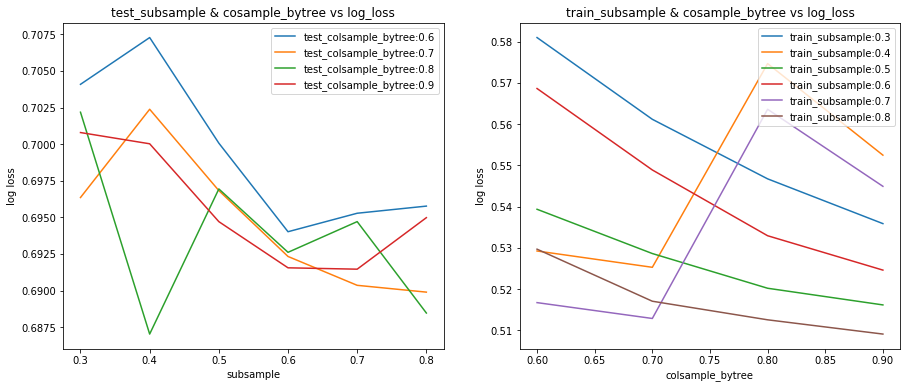

In [18]:
#make plot
print('Best score: %f using %s' % (gsearch_w3_3.best_score_, gsearch_w3_3.best_params_))
test_means_gs3 = gsearch_w3_3.cv_results_['mean_test_score']
test_stds_gs3 = gsearch_w3_3.cv_results_['std_test_score']
train_means_gs3 = gsearch_w3_3.cv_results_['mean_train_score']
train_stds_gs3 = gsearch_w3_3.cv_results_['std_train_score']

pd.DataFrame(gsearch_w3_3.cv_results_).to_csv('preds_maxdepth_min_child_weights_w3_3.csv')

test_scores3 = np.array(test_means_gs3).reshape(len(colsample_bytree), len(subsample))
train_scores3 = np.array(train_means_gs3).reshape(len(subsample), len(colsample_bytree))

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
for i,value in enumerate(colsample_bytree):
    plt.plot(subsample, -test_scores3[i], label = 'test_colsample_bytree:'+str(value))
    
plt.legend()
plt.title('test_subsample & cosample_bytree vs log_loss')
plt.xlabel('subsample')
plt.ylabel('log loss')

plt.subplot(1, 2, 2)
for i,value in enumerate(subsample):
    plt.plot(colsample_bytree, -train_scores3[i], label = 'train_subsample:'+str(value))
plt.legend()
plt.title('train_subsample & cosample_bytree vs log_loss')
plt.xlabel('colsample_bytree')
plt.ylabel('log loss')
plt.show

### Tuning reg_alpha and reg_lambda

In [19]:
reg_alpha = [0.1, 1, 1.5, 2]
reg_lambda = [0.5, 1, 2]

param_test_w3_4 = dict(reg_alpha = reg_alpha, reg_lambda = reg_lambda)
print (param_test_w3_4)

xgb5 = XGBClassifier(n_estimators=33, 
        max_depth=4,
        min_child_weight=4,
        gamma=0,
        subsample=0.4,  #tuned to 0.4
        colsample_bytree=0.9,  #tuned to 0.9
        colsample_bylevel=0.7, objective= 'multi:softprob', seed=3)

gsearch_w3_4 = GridSearchCV(xgb5, param_grid = param_test_w3_4, scoring = 'neg_log_loss', n_jobs = -1, cv=kfold)
gsearch_w3_4.fit(X_train, y_train)
gsearch_w3_4.grid_scores_, gsearch_w3_4.best_params_, gsearch_w3_4.best_score_

{'reg_alpha': [0.1, 1, 1.5, 2], 'reg_lambda': [0.5, 1, 2]}


/Users/hankaei/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.69777, std: 0.01874, params: {'reg_alpha': 0.1, 'reg_lambda': 0.5},
  mean: -0.69709, std: 0.02276, params: {'reg_alpha': 0.1, 'reg_lambda': 1},
  mean: -0.69853, std: 0.01751, params: {'reg_alpha': 0.1, 'reg_lambda': 2},
  mean: -0.70467, std: 0.01848, params: {'reg_alpha': 1, 'reg_lambda': 0.5},
  mean: -0.70207, std: 0.01482, params: {'reg_alpha': 1, 'reg_lambda': 1},
  mean: -0.70672, std: 0.01780, params: {'reg_alpha': 1, 'reg_lambda': 2},
  mean: -0.70383, std: 0.01728, params: {'reg_alpha': 1.5, 'reg_lambda': 0.5},
  mean: -0.70678, std: 0.01892, params: {'reg_alpha': 1.5, 'reg_lambda': 1},
  mean: -0.70806, std: 0.01723, params: {'reg_alpha': 1.5, 'reg_lambda': 2},
  mean: -0.70823, std: 0.01712, params: {'reg_alpha': 2, 'reg_lambda': 0.5},
  mean: -0.70743, std: 0.01690, params: {'reg_alpha': 2, 'reg_lambda': 1},
  mean: -0.70838, std: 0.01724, params: {'reg_alpha': 2, 'reg_lambda': 2}],
 {'reg_alpha': 0.1, 'reg_lambda': 1},
 -0.69709403445576879)

In [20]:
gsearch_w3_4.cv_results_

{'mean_fit_time': array([ 0.57745719,  0.59747062,  0.58265424,  0.55872521,  0.58341312,
         0.59607925,  0.55220509,  0.59964018,  0.51907082,  0.55019002,
         0.58809643,  0.51861215]),
 'mean_score_time': array([ 0.00781646,  0.00545163,  0.00491376,  0.00483975,  0.00931363,
         0.00536857,  0.00529385,  0.00455751,  0.00561242,  0.00573854,
         0.00501528,  0.00379267]),
 'mean_test_score': array([-0.69777229, -0.69709403, -0.69853425, -0.70467257, -0.70206863,
        -0.70672134, -0.70382773, -0.70678101, -0.70805569, -0.7082313 ,
        -0.70742529, -0.70837862]),
 'mean_train_score': array([-0.5400968 , -0.5467967 , -0.55715878, -0.56826548, -0.57141038,
        -0.58065099, -0.5790953 , -0.58276982, -0.59187005, -0.59320221,
        -0.59712068, -0.60304674]),
 'param_reg_alpha': masked_array(data = [0.1 0.1 0.1 1 1 1 1.5 1.5 1.5 2 2 2],
              mask = [False False False False False False False False False False False False],
        fill_value = ?

Best score: -0.697094 using {'reg_alpha': 0.1, 'reg_lambda': 1}


<function matplotlib.pyplot.show>

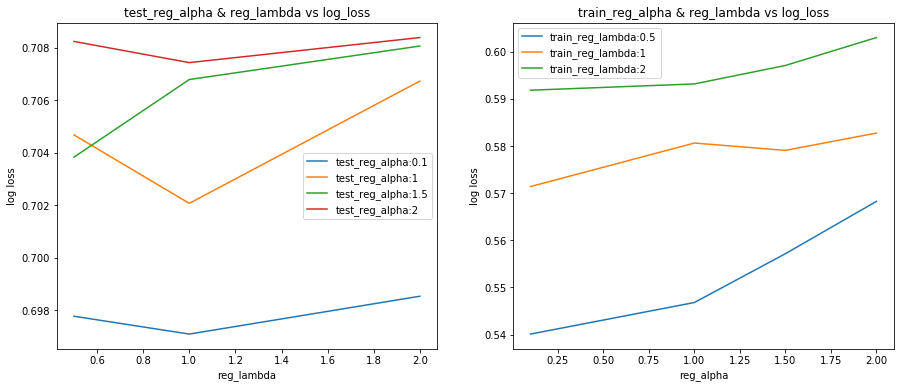

In [21]:
# plot
print('Best score: %f using %s' % (gsearch_w3_4.best_score_, gsearch_w3_4.best_params_))
test_means_gs4 = gsearch_w3_4.cv_results_['mean_test_score']
test_stds_gs4 = gsearch_w3_4.cv_results_['std_test_score']
train_means_gs4 = gsearch_w3_4.cv_results_['mean_train_score']
train_stds_gs4 = gsearch_w3_4.cv_results_['std_train_score']

pd.DataFrame(gsearch_w3_4.cv_results_).to_csv('preds_reg_alpha_reg_lambda.csv')

test_scores4 = np.array(test_means_gs4).reshape(len(reg_alpha), len(reg_lambda))
train_scores4 = np.array(train_means_gs4).reshape(len(reg_lambda), len(reg_alpha))

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
for i,value in enumerate(reg_alpha):
    plt.plot(reg_lambda, -test_scores4[i], label = 'test_reg_alpha:'+str(value))
    
plt.legend()
plt.title('test_reg_alpha & reg_lambda vs log_loss')
plt.xlabel('reg_lambda')
plt.ylabel('log loss')

plt.subplot(1, 2, 2)
for i,value in enumerate(reg_lambda):
    plt.plot(reg_alpha, -train_scores4[i], label = 'train_reg_lambda:'+str(value))
plt.legend()
plt.title('train_reg_alpha & reg_lambda vs log_loss')
plt.xlabel('reg_alpha')
plt.ylabel('log loss')
plt.show

In [33]:
#predict
model = XGBClassifier(n_estimators=33, 
                      max_depth=4,
                      min_child_weight=4,
                      gamma=0,
                      subsample=0.4,  #tuned to 0.4
                      colsample_bytree=0.9,  #tuned to 0.9
                      colsample_bylevel=0.7, 
                      reg_alpha = 0.1,
                      reg_lambda = 1,
                      objective= 'multi:softprob', seed=3)
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=4, missing=None, n_estimators=33,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=3,
       silent=True, subsample=0.4)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_train,y_train,test_size = 0.2, random_state = 0)

In [43]:
#predict the data and get accuracy score on train dataset
pred = model.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, pred)
print('Accuracy: %.2f%%'%(accuracy*100.0))

Accuracy: 80.00%


In [46]:
# predict the test dataset
prediction = model.predict(test.drop(['listing_id'], axis = 1))
prediction

array([2, 1, 2, ..., 2, 1, 2])